<a href="https://colab.research.google.com/github/yukinaga/ai_stock_prediction/blob/main/section_2/01_prediction_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIによるシンプルな株価予測（データの取得・学習・推論）
まずはデータの取得とモデルの学習を行います。  
トヨタ自動車（7203.T）の過去データを使用し、直近のデータをテスト用に取り分けます。

In [1]:
# 必要であればyfinanceをインストール
# !pip install -q yfinance

import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# 1. データの取得 (トヨタ自動車: 7203.T)
# 期間は過去5年分とします
ticker = "7203.T"
df = yf.download(ticker, period="5y", interval="1d")

# 2. 特徴量の作成 (過去5日間の終値を入力データとする)
# AIに「過去5日の動き」を見せて「翌日」を予想させます
lags = 5
for i in range(1, lags + 1):
    df[f'Lag_{i}'] = df['Close'].shift(i)

# 欠損値（過去データがない最初の5日分）を削除
df = df.dropna()

# 3. 学習データと予測ターゲットの準備
# X: 特徴量（過去5日間の終値）
# y: 正解ラベル（その日の実際の終値）
X = df[[f'Lag_{i}' for i in range(1, lags + 1)]]
y = df['Close']

# 時系列データを崩さないように、後半20%をテストデータにする
split_index = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]
test_dates = df.index[split_index:] # 日付データの保持

# 4. モデルの構築と学習 (線形回帰モデル)
model = LinearRegression()
model.fit(X_train, y_train)

# 5. 未来（テストデータ）の予測を実行
predictions = model.predict(X_test)

print("学習と予測が完了しました。")
print(f"学習データ数: {len(X_train)}, テストデータ数: {len(X_test)}")

/tmp/ipython-input-1047230642.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, period="5y", interval="1d")
[*********************100%***********************]  1 of 1 completed

学習と予測が完了しました。
学習データ数: 975, テストデータ数: 244


# 予測結果の評価 その1（視覚化と誤差の計算）
予測がどれくらい当たっているかを、「グラフによる視覚化」と「数値による誤差計測」で評価します。
* RMSE (二乗平均平方根誤差): 値が小さいほど誤差が少ないことを示します。
* MAE: 価格そのものの誤差（何円ズレたか）を示します。
* $R^2$ (決定係数): 1に近いほど予測精度が高いことを示します。

RMSE (誤差の大きさ): 57.55
MAE  (平均絶対誤差): 41.66 円
R2   (決定係数):     0.9238


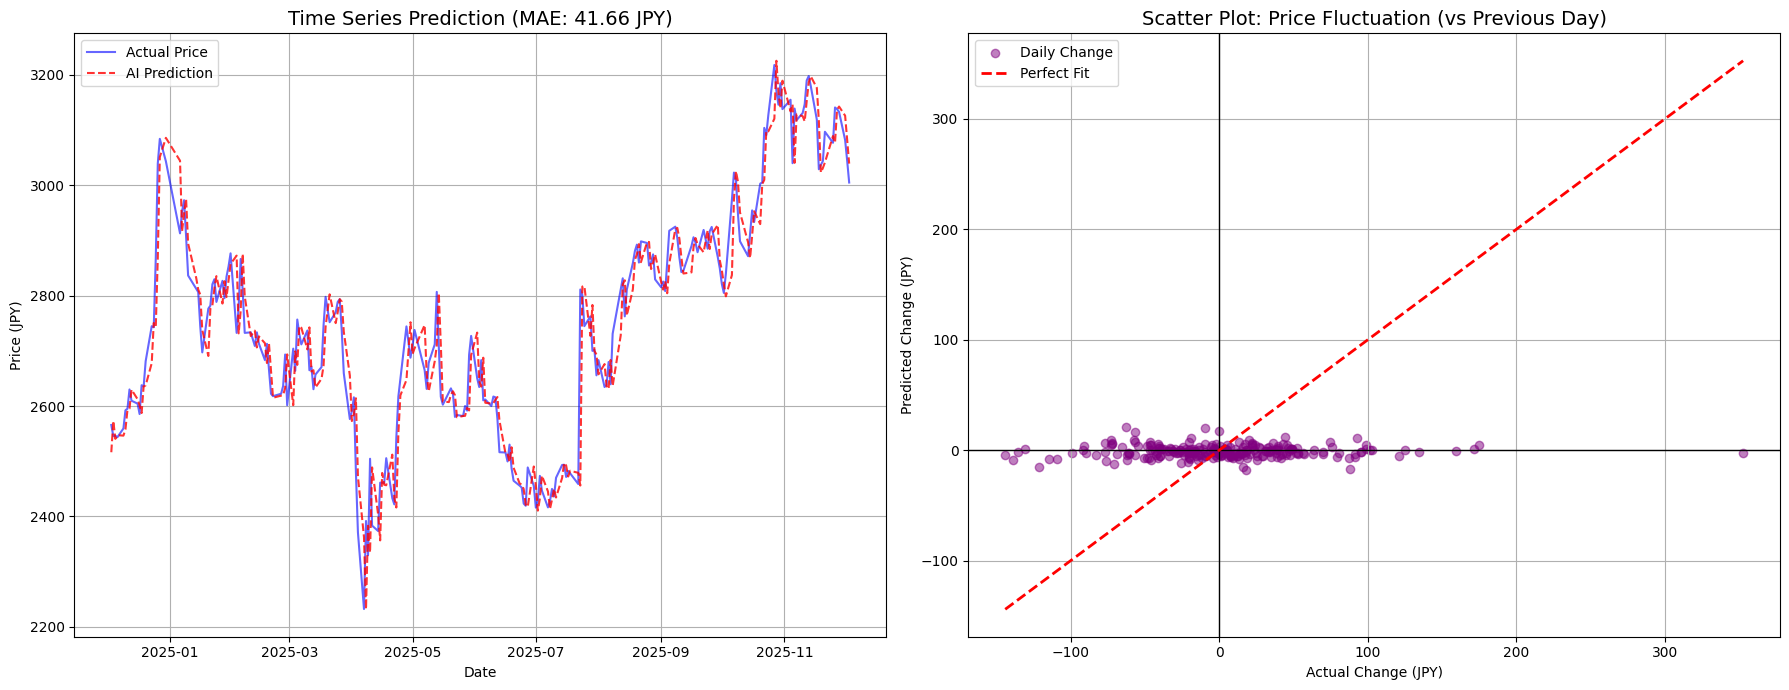

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# --- エラー回避のためのデータ整形 ---
y_test_fixed = y_test.values.ravel() if hasattr(y_test, 'values') else y_test
predictions_fixed = predictions.flatten()

# --- 1. 評価指標の計算 (価格そのものの誤差) ---
mse = mean_squared_error(y_test_fixed, predictions_fixed)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_fixed, predictions_fixed)
r2 = r2_score(y_test_fixed, predictions_fixed)

print(f"RMSE (誤差の大きさ): {rmse:.2f}")
print(f"MAE  (平均絶対誤差): {mae:.2f} 円")
print(f"R2   (決定係数):     {r2:.4f}")

# --- 2. 変動幅（前日比）の計算 ---
# 散布図用に「今日の価格 - 前日の価格」を計算します
# データ配列の[1:]（2日目以降）から[0:-1]（前日）を引きます
actual_diff = y_test_fixed[1:] - y_test_fixed[:-1]
predicted_diff = predictions_fixed[1:] - y_test_fixed[:-1] # 予測値 - (実際の)前日終値

# --- 3. グラフによる可視化 ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# 【左：時系列グラフ】（ここは価格の推移で見ます）
ax1.plot(test_dates, y_test_fixed, label='Actual Price', color='blue', alpha=0.6)
ax1.plot(test_dates, predictions_fixed, label='AI Prediction', color='red', linestyle='--', alpha=0.8)
ax1.set_title(f'Time Series Prediction (MAE: {mae:.2f} JPY)', fontsize=14)
ax1.set_xlabel('Date')
ax1.set_ylabel('Price (JPY)')
ax1.legend()
ax1.grid(True)

# 【右：散布図】（変動幅での評価）
# X軸: 実際の変動幅, Y軸: AIが予測した変動幅
ax2.scatter(actual_diff, predicted_diff, alpha=0.5, color='purple', label='Daily Change')

# ゼロライン（十字線）を追加：ここを見ると「上げ下げの方向」が合っているか分かります
ax2.axhline(0, color='black', linewidth=1)
ax2.axvline(0, color='black', linewidth=1)

# 理想線 (y=x)
min_val = min(actual_diff.min(), predicted_diff.min())
max_val = max(actual_diff.max(), predicted_diff.max())
ax2.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=2, label='Perfect Fit')

ax2.set_title('Scatter Plot: Price Fluctuation (vs Previous Day)', fontsize=14)
ax2.set_xlabel('Actual Change (JPY)')
ax2.set_ylabel('Predicted Change (JPY)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

右側の散布図は、「前日からいくら動いたか」を表しています。

* 右上のエリア（第1象限）: 実際も上がり、AIも上がると予測した（正解）。
* 左下のエリア（第3象限）: 実際も下がり、AIも下がると予測した（正解）。
* 左上のエリア（第2象限）: 実際は下がったのに、AIは上がると予測した（不正解）。
* 右下のエリア（第4象限）: 実際は上がったのに、AIは下がると予測した（不正解）。

点が右上と左下のエリアに多ければ、AIは「方向」を正しく予測できています。

# 予測結果の評価 その2（投資シミュレーション）
「価格を当てること」と「利益が出ること」は別問題です。  
ここでは「AIが『上がる』と予測したら買い、そうでなければ保有しない」 という単純な戦略で、実際に利益が出たかをバックテスト（シミュレーション）します。  
* Strategy Return: AIの予測に従って売買した場合の累積リターン
* Buy & Hold: 期間の初めに買ってずっと持ち続けた場合のリターン

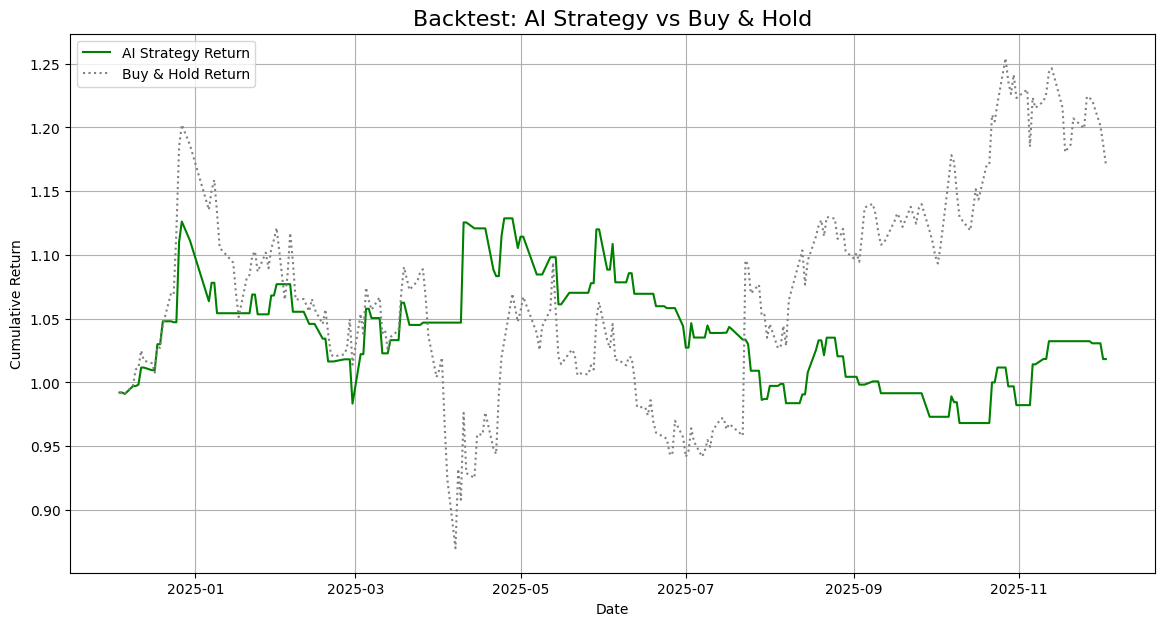

Buy & Hold 最終リターン: 17.12%
AI戦略 最終リターン: 1.83%


In [3]:
# データフレームに結果をまとめる
result_df = pd.DataFrame({
    'Actual': y_test.values.flatten(),   # 実際の価格
    'Predicted': predictions.flatten()   # 予測価格
}, index=test_dates)

# 1. ロジックの構築
# 前日比で「予測値が上昇している」なら翌日は「買いポジション(1)」、そうでなければ「ノーポジション(0)」
# shift(-1)を使わず、予測時点で判断するため、前日の予測値と比較します
result_df['Predicted_Change'] = result_df['Predicted'] - result_df['Actual'].shift(1)
result_df['Signal'] = np.where(result_df['Predicted_Change'] > 0, 1, 0)

# 2. 実際の株価変動率（リターン）を計算
result_df['Actual_Returns'] = result_df['Actual'].pct_change()

# 3. 戦略のリターンを計算（シグナル × 実際の変動率）
# signalは「その日の朝」に決まるため、その日の変動率を掛け合わせます
result_df['Strategy_Returns'] = result_df['Signal'] * result_df['Actual_Returns']

# 4. 累積リターンの計算
cumulative_strategy_returns = (1 + result_df['Strategy_Returns']).cumprod()
cumulative_buy_hold_returns = (1 + result_df['Actual_Returns']).cumprod()

# 5. パフォーマンスの比較グラフ
plt.figure(figsize=(14, 7))
plt.plot(cumulative_strategy_returns, label='AI Strategy Return', color='green')
plt.plot(cumulative_buy_hold_returns, label='Buy & Hold Return', color='gray', linestyle=':')

plt.title('Backtest: AI Strategy vs Buy & Hold', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()

# 最終リターンの表示
print(f"Buy & Hold 最終リターン: {(cumulative_buy_hold_returns.iloc[-1] - 1)*100:.2f}%")
print(f"AI戦略 最終リターン: {(cumulative_strategy_returns.iloc[-1] - 1)*100:.2f}%")